### Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict

In [2]:
df = pd.read_csv("D:\healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.drop(["id"], axis = 1, inplace = True)
df.drop(["work_type"], axis = 1, inplace = True)
# Dropping these columns since they will not help us in determining the actual causations of the stroke risk.

### Explore the Data

In [5]:
df['stroke'].value_counts()


0    4861
1     249
Name: stroke, dtype: int64

#### We see that this dataset is imbalanced. We will have to use strategies that work with these imbalanced datasets such as SMOTE Oversampling. 

In [4]:
df.shape

(5110, 10)

In [6]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [7]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [8]:
pd.isnull(df).sum() 

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [9]:
df = df.dropna()
pd.isnull(df).sum() 
# We drop the null values

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### We will implement graphs to further explore the data and its relationships

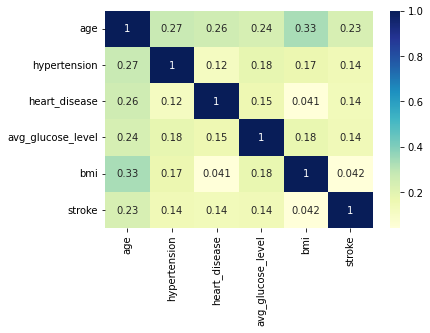

In [10]:
# plotting correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [ ]:
# There is a mild correlation between BMI and age.

Text(0.5, 1.0, 'Age vs Bmi')

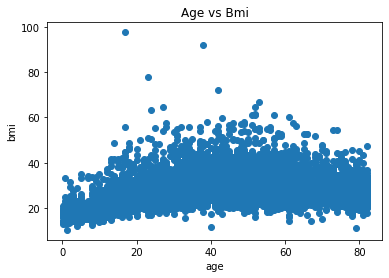

In [11]:
# Scatter plot
plt.scatter(df['age'], df['bmi'])
plt.xlabel('age')              # label = name of label
plt.ylabel('bmi')
plt.title('Age vs Bmi') 

In [ ]:
# appears to be weak association between age and BMI. This was also seen in the heatmap.

Text(0.5, 1.0, 'Age vs Stroke')

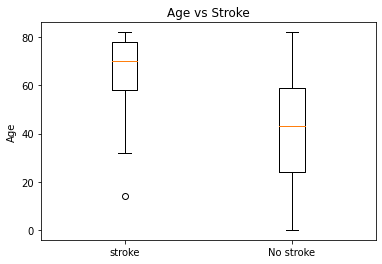

In [12]:
# Boxplot
plt.boxplot([df[df['stroke']==1]['age'], df[df['stroke']!=1]['age']], labels = ["stroke", "No stroke"])
plt.ylabel('Age')
plt.title('Age vs Stroke')

### CVA risk, aka Stroke risk is higher in the elderly population (60 and over) compared to the adults in the 30-60 years old range. 

Text(0.5, 1.0, 'gluc. level vs Stroke')

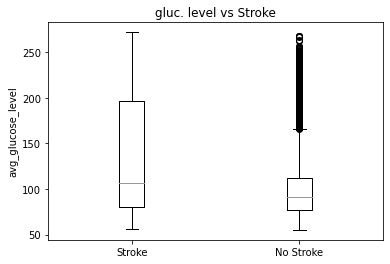

In [13]:
plt.boxplot([df[df['stroke']==1]['avg_glucose_level'], df[df['stroke']!=1]['avg_glucose_level']], labels = ["Stroke", "No Stroke"])
plt.ylabel('avg_glucose_level')
plt.title('gluc. level vs Stroke')

In [14]:
# There is a higher risk of stroke with increased average glucose levels in the bloodstream. This is expected. 
# There are alot of outliers in the "No Sroke" boxplot.

In [15]:
print(df.age.min())
print(df.age.max())

0.08
82.0


<AxesSubplot:ylabel='Frequency'>

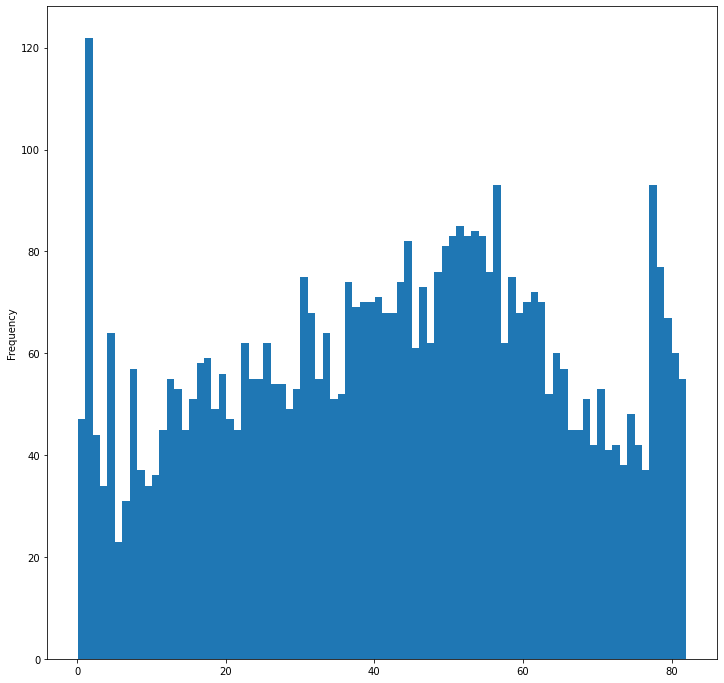

In [16]:
# Age Histogram
df.age.plot(kind = 'hist',bins = 82,figsize = (12,12))


In [17]:
print(df.gender.unique())
print(df.ever_married.unique())
print(df.smoking_status.unique())
print(df.Residence_type.unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
['Urban' 'Rural']


### Encode Columns

In [18]:
categorical_cols = ['gender', 'ever_married', "smoking_status", "Residence_type"] 

df = pd.get_dummies(df, columns = categorical_cols)

In [19]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Rural,Residence_type_Urban
0,67.0,0,1,228.69,36.6,1,0,1,0,0,1,0,1,0,0,0,1
2,80.0,0,1,105.92,32.5,1,0,1,0,0,1,0,0,1,0,1,0
3,49.0,0,0,171.23,34.4,1,1,0,0,0,1,0,0,0,1,0,1
4,79.0,1,0,174.12,24.0,1,1,0,0,0,1,0,0,1,0,1,0
5,81.0,0,0,186.21,29.0,1,0,1,0,0,1,0,1,0,0,0,1


### Scale the data

In [26]:
# Scale the data without scaling the encoded variables
col_names = ['age', 'avg_glucose_level', 'bmi']
features = df[col_names]
ct = ColumnTransformer([
        ('somename', StandardScaler(), ['age', 'avg_glucose_level', 'bmi'])
    ], remainder='passthrough')

scaled_feat=ct.fit_transform(features)

In [27]:
df_new=df.copy()
df_new.loc[:,['age', 'avg_glucose_level', 'bmi']] = scaled_feat

In [29]:
df_new[['age', 'avg_glucose_level', 'bmi']].head()

,age,avg_glucose_level,bmi
0,1.070138,2.777698,0.981345
2,1.646563,0.013842,0.459269
3,0.272012,1.484132,0.701207
4,1.602222,1.549193,-0.623083
5,1.690903,1.821368,0.013595


In [31]:
target_col = "stroke"
x = df_new.drop(target_col, axis=1)
y = df_new[target_col]

In [32]:
x

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Rural,Residence_type_Urban
0,1.070138,0,1,2.777698,0.981345,0,1,0,0,1,0,1,0,0,0,1
2,1.646563,0,1,0.013842,0.459269,0,1,0,0,1,0,0,1,0,1,0
3,0.272012,0,0,1.484132,0.701207,1,0,0,0,1,0,0,0,1,0,1
4,1.602222,1,0,1.549193,-0.623083,1,0,0,0,1,0,0,1,0,1,0
5,1.690903,0,0,1.821368,0.013595,0,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,-1.324241,0,0,-0.050094,-1.310695,1,0,0,1,0,1,0,0,0,1,0
5106,1.690903,0,0,0.447882,1.414286,1,0,0,0,1,0,0,1,0,0,1
5107,-0.348753,0,0,-0.502369,0.217332,1,0,0,0,1,0,0,1,0,1,0
5108,0.360692,0,0,1.372920,-0.419346,0,1,0,0,1,0,1,0,0,1,0


### Train Test Split

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

In [34]:
x_train.std(0)

age                               0.998615
hypertension                      0.284595
heart_disease                     0.215670
avg_glucose_level                 0.998529
bmi                               1.002441
gender_Female                     0.491705
gender_Male                       0.491658
gender_Other                      0.015958
ever_married_No                   0.478258
ever_married_Yes                  0.478258
smoking_status_Unknown            0.460170
smoking_status_formerly smoked    0.374425
smoking_status_never smoked       0.486116
smoking_status_smokes             0.351524
Residence_type_Rural              0.500048
Residence_type_Urban              0.500048
dtype: float64

In [35]:
x_train.shape
# The 16 columns shows that the encoding worked since we started with 9 columns

(3927, 16)

In [36]:
y_train.shape

(3927,)

### Logistic Regression

In [37]:
# logisitic model
lr = LogisticRegression(max_iter=800)
y_lr =cross_val_predict(lr,x , y, cv=None)
print('Logistic AUC: {:.3f}'.format(roc_auc_score(y, y_lr)))

Logistic AUC: 0.502


### Decision Tree

In [40]:
# decision tree model
tree = DecisionTreeClassifier(max_depth=8)
y_tree = cross_val_predict(tree, x, y, cv=None, groups=y)
print('Tree AUC: {:.3f}'.format(roc_auc_score(y, y_tree)))


Tree AUC: 0.513


### Random Forest

In [41]:
# Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=8)
y_rf = cross_val_predict(rf, x, y, cv=None, groups=y) ## **randomly shuffle output (may be)
print('RF AUC: {:.3f}'.format(roc_auc_score(y, y_rf)))

RF AUC: 0.502


In [42]:
# xgboost (boosting)
xgb = XGBClassifier(n_estimators=15, max_depth=20, eval_metric ='logloss', use_label_encoder=False)
y_xgb = cross_val_predict(xgb, x, y, cv=None, groups=y)
print('XGB AUC: {:.3f}'.format(roc_auc_score(y, y_xgb)))

XGB AUC: 0.510


### All of these models performed poorly but this is a imbalanced dataset. We will use SMOTE.

## SMOTE

In [115]:
from imblearn.over_sampling import SMOTE

In [135]:
x_train_over.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Rural,Residence_type_Urban
0,-0.836497,0,0,-0.716238,-0.686751,1,0,0,1,0,0,0,1,0,0,1
1,-0.747817,0,0,-0.360766,-0.915955,1,0,0,1,0,0,0,0,1,0,1
2,-0.925178,0,0,-0.716013,1.579822,1,0,0,1,0,0,0,0,1,0,1
3,1.557882,0,0,-0.645323,0.726674,1,0,0,1,0,0,0,1,0,1,0
4,0.981457,0,0,-0.376750,0.013595,0,1,0,0,1,0,0,0,1,0,1


### Oversampling Technique

In [116]:
oversample=SMOTE()
x_train_over,y_train_over=oversample.fit_resample(x_train,y_train)

In [117]:
y_train.value_counts()

0    3760
1     167
Name: stroke, dtype: int64

In [118]:
y_train_over.value_counts()

0    3760
1    3760
Name: stroke, dtype: int64

#### Oversampling is preferred over undersampling since there are so few positive stroke values and you want to retain all the information.

In [127]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=0)
rf.fit(x_train_over,y_train_over)

RandomForestClassifier(max_depth=10, random_state=0)

In [128]:
y_rf2=rf.predict(x_test)

In [129]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_rf2)

array([[802, 138],
       [ 22,  20]], dtype=int64)

In [130]:
roc_auc_score(y_test, y_rf2)

0.6646909827760892

### Lets try to improve the model using GridSearchCV

In [136]:
from sklearn.model_selection import GridSearchCV

In [137]:
rf = RandomForestClassifier(random_state=0)
params={'n_estimators':[20,50,100,200,500],'max_depth':[2,5,10,50,100,200],'min_samples_split':[5,10,50,100]}
grid_search=GridSearchCV(rf,params,cv=3)

grid_search.fit(x_train_over,y_train_over)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 5, 10, 50, 100, 200],
                         'min_samples_split': [5, 10, 50, 100],
                         'n_estimators': [20, 50, 100, 200, 500]})

In [138]:
grid_search.best_params_

{'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 500}

In [154]:
model=RandomForestClassifier(n_estimators=500, max_depth=50,min_samples_split=5,random_state=0,class_weight={0:0.5,1:0.2})

In [155]:
model.fit(x_train_over,y_train_over)

RandomForestClassifier(class_weight={0: 0.5, 1: 0.2}, max_depth=50,
                       min_samples_split=5, n_estimators=500, random_state=0)

In [156]:
y_pred3=model.predict(x_test)

In [157]:
roc_auc_score(y_test, y_pred3)

0.5649189463019251

In [158]:
confusion_matrix(y_test,y_pred3)

array([[883,  57],
       [ 34,   8]], dtype=int64)

#### Our results show that we have less true positives and more false negatives, however we have much less false positives which is a good thing. Lets use a Neural Network for classification.

## Neural Network

In [159]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [160]:
x_train.shape

(3927, 16)

#### Building the ANN

In [239]:
model=Sequential()
model.add(Dense(32,input_dim=x_train.shape[1],activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [240]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['AUC'])

#### Fitting the ANN

In [241]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
123/123 [==============================] - 1s 2ms/step - loss: 0.2355 - auc: 0.5222 - val_loss: 0.1604 - val_auc: 0.7592
Epoch 2/10
123/123 [==============================] - 0s 900us/step - loss: 0.1549 - auc: 0.7770 - val_loss: 0.1457 - val_auc: 0.8309
Epoch 3/10
123/123 [==============================] - 0s 959us/step - loss: 0.1441 - auc: 0.8314 - val_loss: 0.1419 - val_auc: 0.8440
Epoch 4/10
123/123 [==============================] - 0s 946us/step - loss: 0.1410 - auc: 0.8462 - val_loss: 0.1416 - val_auc: 0.8436
Epoch 5/10
123/123 [==============================] - 0s 1ms/step - loss: 0.1393 - auc: 0.8504 - val_loss: 0.1423 - val_auc: 0.8438
Epoch 6/10
123/123 [==============================] - 0s 921us/step - loss: 0.1378 - auc: 0.8554 - val_loss: 0.1469 - val_auc: 0.8460
Epoch 7/10
123/123 [==============================] - 0s 964us/step - loss: 0.1372 - auc: 0.8568 - val_loss: 0.1417 - val_auc: 0.8446
Epoch 8/10
123/123 [==============================] - 0s 927us/ste

In [260]:
y_pred_NN=(model.predict(x_test)>0.10).astype(int).ravel()

#### Confusion Matrix

In [261]:
confusion_matrix(y_test,y_pred_NN)

array([[824, 116],
       [ 18,  24]], dtype=int64)

In [262]:
roc_auc_score(y_test, y_pred_NN)

0.7240121580547112

In [263]:
## FN are more critical --> minimize this value as much as possible
## FP

In [264]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_NN))

              precision    recall  f1-score   support

           0       0.98      0.88      0.92       940
           1       0.17      0.57      0.26        42

    accuracy                           0.86       982
   macro avg       0.58      0.72      0.59       982
weighted avg       0.94      0.86      0.90       982



#### Although this model had the highest accuracy at 86%, its precision was only 17% for positive stroke patients, but did have a reasonable Recall. This is what makes a model difficult for imbalanced data.

### CVA risk, aka Stroke risk is higher in the elderly population (60 and over) compared to the adults in the 30-60 years old range. This is due to atherosclerosis of the arteries that occurs over decades and the buidup of choleseterol leads to plaques on the vessel walls that can break off and result in an ischemic stroke. An hemmorhagic stroke occurs when there is bleeding in the brain and that has a higher incidence in the elderly since they are more prone to falls and usually take aspirin or another type of blood thinner to decrease their risk of ischemic stroke.